In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import print_function
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import os

%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [2]:
os.chdir('C:/temp/expedia-hotel-recommendations')

In [3]:
%%time
df = pd.read_csv('train.csv', nrows=10000, index_col=0)
df = df.reset_index(drop=True)

Wall time: 47.7 ms


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   site_name                  10000 non-null  int64  
 1   posa_continent             10000 non-null  int64  
 2   user_location_country      10000 non-null  int64  
 3   user_location_region       10000 non-null  int64  
 4   user_location_city         10000 non-null  int64  
 5   orig_destination_distance  6271 non-null   float64
 6   user_id                    10000 non-null  int64  
 7   is_mobile                  10000 non-null  int64  
 8   is_package                 10000 non-null  int64  
 9   channel                    10000 non-null  int64  
 10  srch_ci                    9993 non-null   object 
 11  srch_co                    9993 non-null   object 
 12  srch_adults_cnt            10000 non-null  int64  
 13  srch_children_cnt          10000 non-null  int6

In [5]:
df.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2,3,66,348,48862,2234.2641,12,0,1,9,...,0,1,8250,1,0,3,2,50,628,1
1,2,3,66,348,48862,2234.2641,12,0,1,9,...,0,1,8250,1,1,1,2,50,628,1
2,2,3,66,348,48862,2234.2641,12,0,0,9,...,0,1,8250,1,0,1,2,50,628,1
3,2,3,66,442,35390,913.1932,93,0,0,3,...,0,1,14984,1,0,1,2,50,1457,80
4,2,3,66,442,35390,913.6259,93,0,0,3,...,0,1,14984,1,0,1,2,50,1457,21


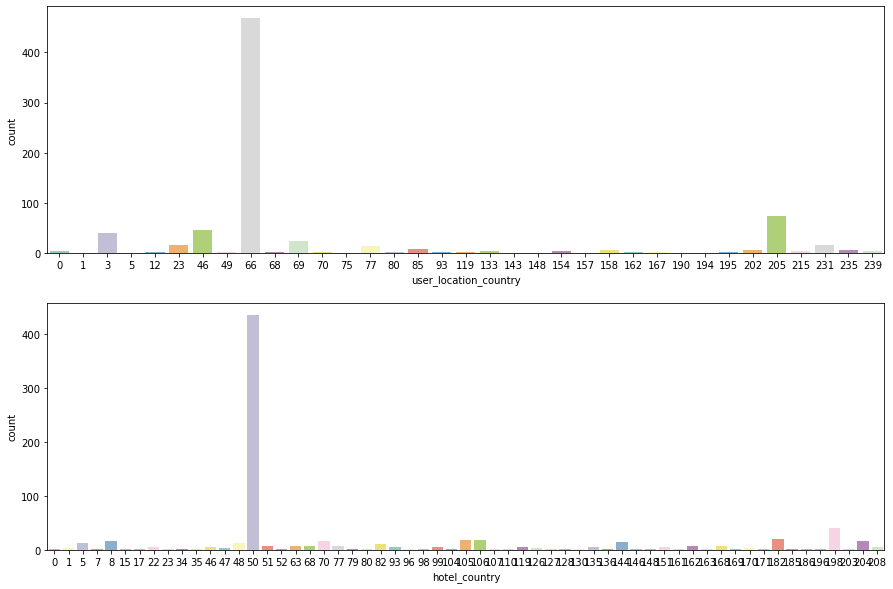

In [6]:
fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,10))

bookings_df = df[df["is_booking"] == 1]

# 여행을 많이 가는 사람들의 나라
sns.countplot('user_location_country',data=bookings_df.sort_values(by=['user_location_country']),ax=axis1,palette="Set3")

# 여행지로 가장 많이 선택되는 나라
sns.countplot('hotel_country',data=bookings_df.sort_values(by=['hotel_country']),ax=axis2,palette="Set3")

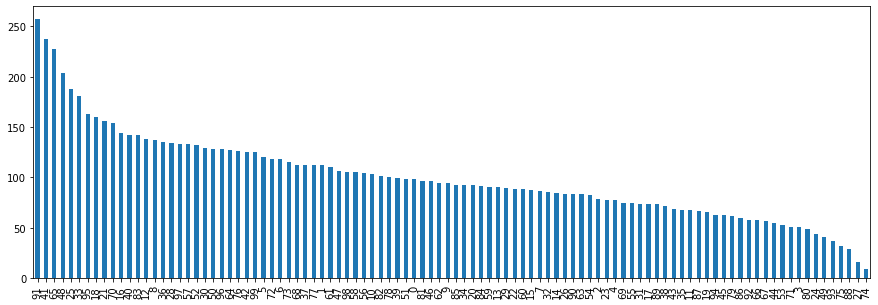

In [7]:
# 호텔 인기 유형 개수 카운팅
df["hotel_cluster"].value_counts().plot(kind='bar',figsize=(15,5))

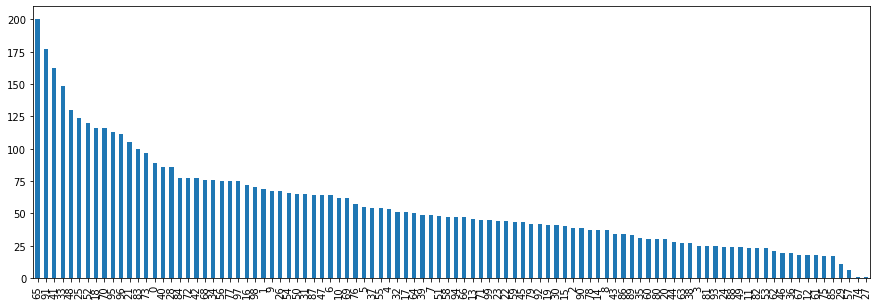

In [8]:
# 66번 나라의 인기 유형
user_country_id = 66

fig, (axis1) = plt.subplots(1,1,figsize=(15,10))

customer_clusters = df[df["user_location_country"] == user_country_id]["hotel_cluster"]
customer_clusters.value_counts().plot(kind='bar',figsize=(15,5))

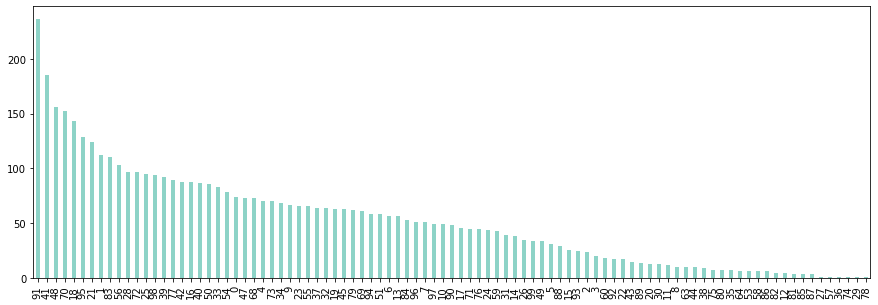

In [9]:
# 50번 나라의 호텔 유형 분류
country_id = 50

fig, (axis1) = plt.subplots(1,1,figsize=(15,10))

country_clusters = df[df["hotel_country"] == country_id]["hotel_cluster"]
country_clusters.value_counts().plot(kind='bar',colormap="Set3",figsize=(15,5))

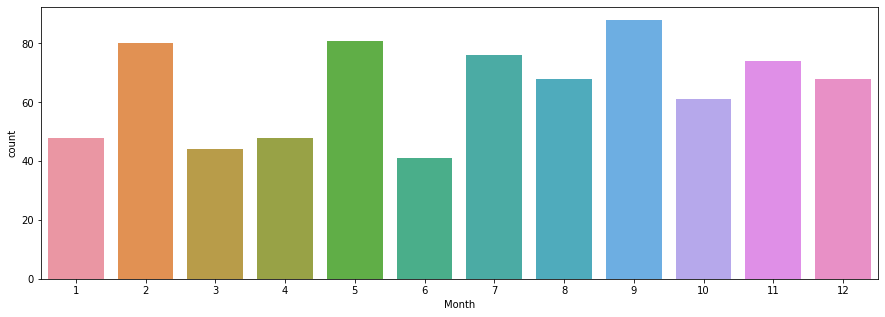

In [10]:
# 월별 예약 건수 
df['Year']   = df['srch_ci'].apply(lambda x: int(str(x)[:4]) if x == x else np.nan)
df['Month']  = df['srch_ci'].apply(lambda x: int(str(x)[5:7]) if x == x else np.nan)
df['Week']   = df['srch_ci'].apply(lambda x: int(str(x)[8:10]) if x == x else np.nan)

fig, axis1 = plt.subplots(figsize=(15,5))

sns.countplot('Month',data=df[df["is_booking"] == 1],order=list(range(1,13)),ax=axis1)

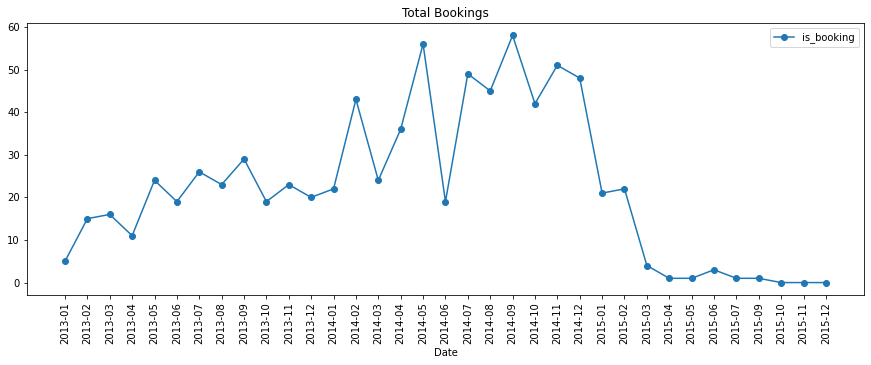

In [11]:
# 예약건수
df['Date']  = df['srch_ci'].apply(lambda x: (str(x)[:7]) if x == x else np.nan)

date_bookings  = df.groupby('Date')["is_booking"].sum()
ax1 = date_bookings.plot(legend=True,marker='o',title="Total Bookings", figsize=(15,5)) 
ax1.set_xticks(range(len(date_bookings)))
xlabels = ax1.set_xticklabels(date_bookings.index.tolist(), rotation=90)

In [12]:
train = pd.read_csv('train.csv',
                    dtype={'is_booking':bool,'srch_destination_id':np.int32, 'hotel_cluster':np.int32},
                    usecols=['srch_destination_id','is_booking','hotel_cluster'],
                    chunksize=1000000)

aggs = []
print('-'*38)
for chunk in train:
    agg = chunk.groupby(['srch_destination_id',
                         'hotel_cluster'])['is_booking'].agg(['sum','count'])
    agg.reset_index(inplace=True)
    aggs.append(agg)
    print('.',end='')
    
print('')

aggs = pd.concat(aggs, axis=0)

agg = aggs.groupby(['srch_destination_id','hotel_cluster']).sum().reset_index()
agg.head()

agg['count'] -= agg['sum']
agg = agg.rename(columns={'sum':'bookings','count':'clicks'})
agg['relevance'] = agg['bookings'] + 0.1 * agg['clicks']

print("preprocess end")

def most_popular(group, n_max=5):
    relevance = group['relevance'].values
    hotel_cluster = group['hotel_cluster'].values
    most_popular = hotel_cluster[np.argsort(relevance)[::-1]][:n_max]
    return np.array_str(most_popular)[1:-1] 

most_pop = agg.groupby(['srch_destination_id']).apply(most_popular)
most_pop = pd.DataFrame(most_pop).rename(columns={0:'hotel_cluster'})

train_df = pd.read_csv("train.csv", 
                       usecols=['srch_destination_id','is_booking','hotel_cluster', 'user_location_city', 'orig_destination_distance'])

test = pd.read_csv('test.csv',
                    dtype={'srch_destination_id':np.int32},
                    usecols=['srch_destination_id', 'user_location_city', 'orig_destination_distance'])

test = test.merge(most_pop, how='left',left_on='srch_destination_id',right_index=True)

train_df = train_df.fillna(-1)
train_df = train_df[train_df["is_booking"] == 1]
np.random.seed(402)

train_x = train_df.iloc[:,:3]
train_y = train_df.iloc[:,4]

model = RandomForestClassifier(n_estimators=10, max_depth=7, n_jobs=-1, random_state=777)

model.fit(train_x,train_y)

test1 = test.fillna(-1)
test1 = test1.drop("hotel_cluster", axis=1)

preds = model.predict_proba(test1)
preds = np.fliplr(np.argsort(preds, axis=1))

random_model = pd.DataFrame([ " ".join(row) for row in preds[:,:4].astype(str)], columns=["hotel_cluster"])

test_sample = test.reset_index()
test1 = test1.reset_index()


test1 = pd.concat([test1,random_model], axis=1)

test1 = test1[["index","hotel_cluster"]]

result_df = test_sample.merge(test1, how = "left", on="index", copy=False)
result_df = result_df.fillna("")
result_df = result_df["hotel_cluster_x"]
result_df = result_df.to_frame(name="hotel_cluster")
result_df.index.names = ["id"]

--------------------------------------
......................................
preprocess end


In [13]:
result_df

,hotel_cluster
id,
0,5 37 55 11 22
1,5
2,0 31 96 91 77
3,1 45 79 24 54
4,91 42 2 48 59
...,...
2528238,26 73 84 0 34
2528239,57
2528240,1 45 79 24 54


In [14]:
result_df.to_csv('submission.csv')